In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim

from ConvBN import ConvBN as ConvBN_BiasTrick
from LinearBN import LinearBN
from scipy.io import loadmat, savemat

In [2]:
class LReLU(nn.Module):
    def __init__(self):
        super(LReLU, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(5.0)) 
    def forward(self, x):
        return torch.nn.functional.relu(self.alpha*x)

In [3]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size= 10000
num_workers=2
pin_memory=True

train_set = torchvision.datasets.CIFAR10(root='../Data', train=True, download=True, transform=train_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

test_set = torchvision.datasets.CIFAR10(root='../Data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA is available


In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.in_dim = 3
        self.conv1_out = 32
        self.conv1_size = 5
        self.conv1_padding = 2


        self.conv2_out = 64
        self.conv2_size = 3
        self.conv2_padding = 1

        self.fc1_out = 512
        self.fc2_out = 10

        self.q = 1e-6
        self.bias_trick_par = nn.Parameter(torch.tensor(0.00005))

        # First Convolutional Block

        self.block1 = ConvBN_BiasTrick(in_channels=self.in_dim, out_channels=self.conv1_out,
                             kernel_size=self.conv1_size, padding=self.conv1_padding, std = .1, seed=100) # To change the seed ================
        # Second Convolutional Block

        self.block2 = ConvBN_BiasTrick(in_channels=self.conv1_out, out_channels=self.conv2_out,
                 kernel_size=3, stride=1, padding=1, std = .05, seed=200) # To change the seed ====================================
       
        self.block3 = LinearBN(in_features = self.conv2_out * (32//2 //2) * (32//2 //2), 
                                         out_features=self.fc1_out, seed=300) # To change the seed ================================
        
        
        self.w2 = nn.Parameter(torch.randn(self.fc1_out, self.fc2_out))
        nn.init.normal_(self.w2, mean=0.0, std=.6)

        self.dropout = nn.Dropout(0.5)
        self.dropout2d = nn.Dropout2d(0.3)

        self.relu = LReLU()

    def custom_round(self, n):
        remainder = n % 1000
        base = n - remainder
        if remainder >= 101:
            return base + 1000
        elif remainder <= 100:
            return base
            

    def forward(self, x):
        
        x = F.max_pool2d(self.relu(self.block1(x)), (2,2), padding=0)
        x = F.max_pool2d(self.relu(self.block2(x)), (2,2), padding=0)
        x = self.dropout2d(x)
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.block3(x))

        x = x + self.bias_trick_par
        x_norm = x / (x.norm(p=2, dim=1, keepdim=True) + self.q)  # Normalize input x
        w2_norm = self.w2 / (self.w2.norm(p=2, dim=1, keepdim=True) + self.q)  # Normalize weights
        x = torch.matmul(x_norm, w2_norm) # Matrix multiplication 

        # Return raw logits (no softmax here, CrossEntropyLoss handles it)
        return x

    def init_hd(self, ratio, seed):
        if not isinstance(ratio, (tuple, int)):
            raise TypeError("ratio must be a tuple of size 3 or and integer")

        elif isinstance(ratio, (int)):
            ratio = (ratio, ratio, ratio, ratio)
            
        if not isinstance(seed, (tuple)):
            raise TypeError("seed must be a tuple of size 3")
        
        self.block1.init_hd(ratio = ratio[0], seed = seed[0])
        self.block2.init_hd(ratio = ratio[1], seed = seed[1])
        self.block3.init_hd(ratio = ratio[2], seed = seed[2])

        torch.manual_seed(400) # To change the seed ========================================================
        
        n_last = self.w2.size(0)
        self.nHD_last = int(self.custom_round(ratio[3] * n_last)) if ratio[3]<1000 else int(ratio[3])
        torch.manual_seed(seed[3])
        self.g = torch.sign(torch.randn(self.w2.size(0), self.nHD_last, device=self.w2.device)).to(torch.half)
        self.wg = torch.sign(torch.matmul(self.g.t(), self.w2.to(torch.half)))

        # print(f'Block1: {self.block1.nHD}, Block2: {self.block2.nHD}, Block3: {self.block3.nHD}, Classification Layer: {nHD_last}')

    def hd(self, x):
        x = F.max_pool2d(self.relu(self.block1.hd(x)), (2,2), padding=0)
        x = F.max_pool2d(self.relu(self.block2.hd(x)), (2,2), padding=0)

        x = x.view(x.size(0), -1)
        x = self.relu(self.block3.hd(x))

        x = x + self.bias_trick_par
        x = torch.sign(torch.matmul(x.to(torch.half), self.g))

        return x
        
    def classification_layer(self, x):
        x = x @ self.wg
        return x


In [7]:
from tqdm import tqdm
import time
from torch.nn.parallel import data_parallel
from torch.utils.data import Subset


torch.cuda.empty_cache()
model = Network().to(device)
model.load_state_dict(torch.load('GNet_Trained_Model_84.85%.pth', weights_only = True))


model.to(torch.half).to(device)
model.eval()
torch.manual_seed(42)
n_splits = 20
split_size = len(test_set) // n_splits  # 10000 // 20 = 500
scales = np.arange(0.6, 1.47, 0.08)
accuracies = np.zeros((len(scales), n_splits))
times = []
hyperdims = np.zeros((len(scales), 4))
for i, scale in enumerate(scales):
    scale = round(scale, 2)
    ratio = (15, 1, 9.6, 10)
    ratio = tuple(scale * r for r in ratio)
    for split_idx in tqdm(range(n_splits)):
        start_idx = split_idx * split_size
        end_idx = start_idx + split_size
        split_subset = Subset(test_set, range(start_idx, end_idx))
        split_loader = torch.utils.data.DataLoader(split_subset, batch_size=1, shuffle=False,
                                                   num_workers=num_workers, pin_memory=pin_memory)
        
        torch.manual_seed(split_idx)
        random_seeds = tuple(torch.randint(0, 1000, (1,)).item() for _ in range(4))
        model.init_hd(ratio, random_seeds)
        hyperdims[i] = np.array([model.block1.nHD, model.block2.nHD, model.block3.nHD, model.nHD_last])
        correct = 0
        total = 0
    
        t0 = time.time()
        with torch.no_grad():
            for images, labels in split_loader:
                images, labels = images.cuda(non_blocking=True), labels.cuda(non_blocking=True)
                output = model.hd(images.to(torch.half))
                output = model.classification_layer(output.to(torch.half))
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        t1 = time.time()
    
        acc = 100 * correct / total
        dt = t1 - t0
    
        accuracies[i, split_idx] = acc
        times.append(dt)
    
    print(f'Block1: {model.block1.nHD}, Block2: {model.block2.nHD}, Block3: {model.block3.nHD} Classification Layer: {model.nHD_last}, Average Accuracy: {np.mean(accuracies[i]):.2f}%')


100%|██████████| 20/20 [05:03<00:00, 15.16s/it]


Block1: 22000, Block2: 11000, Block3: 24000 Classification Layer: 3000, Average Accuracy: 77.80%


100%|██████████| 20/20 [05:47<00:00, 17.37s/it]


Block1: 25000, Block2: 13000, Block3: 27000 Classification Layer: 4000, Average Accuracy: 78.14%


100%|██████████| 20/20 [06:22<00:00, 19.14s/it]


Block1: 28000, Block2: 14000, Block3: 30000 Classification Layer: 4000, Average Accuracy: 79.39%


100%|██████████| 20/20 [07:09<00:00, 21.47s/it]


Block1: 31000, Block2: 16000, Block3: 33000 Classification Layer: 5000, Average Accuracy: 79.73%


100%|██████████| 20/20 [07:46<00:00, 23.35s/it]


Block1: 34000, Block2: 17000, Block3: 37000 Classification Layer: 5000, Average Accuracy: 79.89%


100%|██████████| 20/20 [08:21<00:00, 25.08s/it]


Block1: 36000, Block2: 19000, Block3: 40000 Classification Layer: 6000, Average Accuracy: 80.20%


100%|██████████| 20/20 [09:01<00:00, 27.06s/it]


Block1: 39000, Block2: 20000, Block3: 43000 Classification Layer: 6000, Average Accuracy: 80.57%


100%|██████████| 20/20 [09:43<00:00, 29.16s/it]


Block1: 42000, Block2: 22000, Block3: 46000 Classification Layer: 6000, Average Accuracy: 80.62%


100%|██████████| 20/20 [10:22<00:00, 31.10s/it]


Block1: 45000, Block2: 23000, Block3: 49000 Classification Layer: 7000, Average Accuracy: 80.85%


100%|██████████| 20/20 [11:07<00:00, 33.35s/it]


Block1: 48000, Block2: 25000, Block3: 52000 Classification Layer: 7000, Average Accuracy: 81.30%


100%|██████████| 20/20 [11:45<00:00, 35.30s/it]

Block1: 51000, Block2: 26000, Block3: 55000 Classification Layer: 8000, Average Accuracy: 81.37%


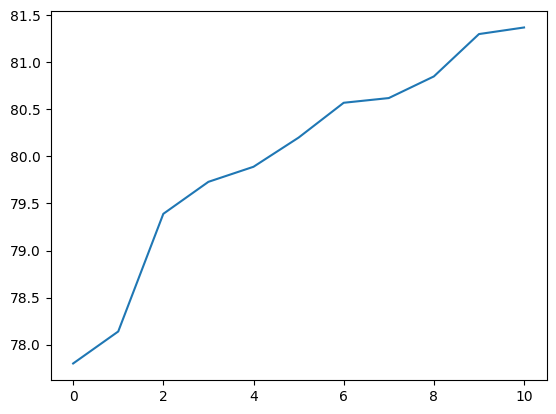

In [8]:
np.mean(accuracies, axis=1)
import matplotlib.pyplot as plt
plt.plot(np.mean(accuracies, axis=1))

In [9]:
savemat('EHDGNet_CIFAR10.mat', {'EHDGNet_CIFAR10':accuracies})

In [10]:
savemat('EHDGNet_CIFAR10_nHD.mat', {'EHDGNet_CIFAR10_nHD': hyperdims})